# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import Polygon
from sklearn.preprocessing import StandardScaler
import joblib
from datetime import datetime
import sys
from rasterio.plot import show

# Load Data

In [9]:
time_series_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\time_series"

def load_tif_files(include_s1b=False):
    """Load the list of TIFF files, optionally excluding those starting with 'S1B'."""
    tif_files = [f for f in os.listdir(time_series_dir) if f.endswith('.tif')]
    if not include_s1b:
        tif_files = [f for f in tif_files if not f.startswith('S1B')]
    return sorted(tif_files)

# Set the flag to include or exclude S1B files
include_s1b = True

# Load TIFF files based on the include_s1b flag
tif_files = load_tif_files(include_s1b=include_s1b)

# Load a sample TIFF file to extract coordinate bounds
sample_tif_path = os.path.join(time_series_dir, tif_files[0])

# Determine the Coordinate Range
with rasterio.open(sample_tif_path) as src:
    bounds = src.bounds
    crs = src.crs
    
# Print the coordinate range
print(f"Coordinate Reference System (CRS): {crs}")
print(f"Coordinate Range (Bounding Box):")
print(f"  Min Longitude (West): {bounds.left}")
print(f"  Max Longitude (East): {bounds.right}")
print(f"  Min Latitude (South): {bounds.bottom}")
print(f"  Max Latitude (North): {bounds.top}")

Coordinate Reference System (CRS): EPSG:32720
Coordinate Range (Bounding Box):
  Min Longitude (West): 845580.0
  Max Longitude (East): 847160.0
  Min Latitude (South): 9329240.0
  Max Latitude (North): 9331190.0


### Define the Polygon

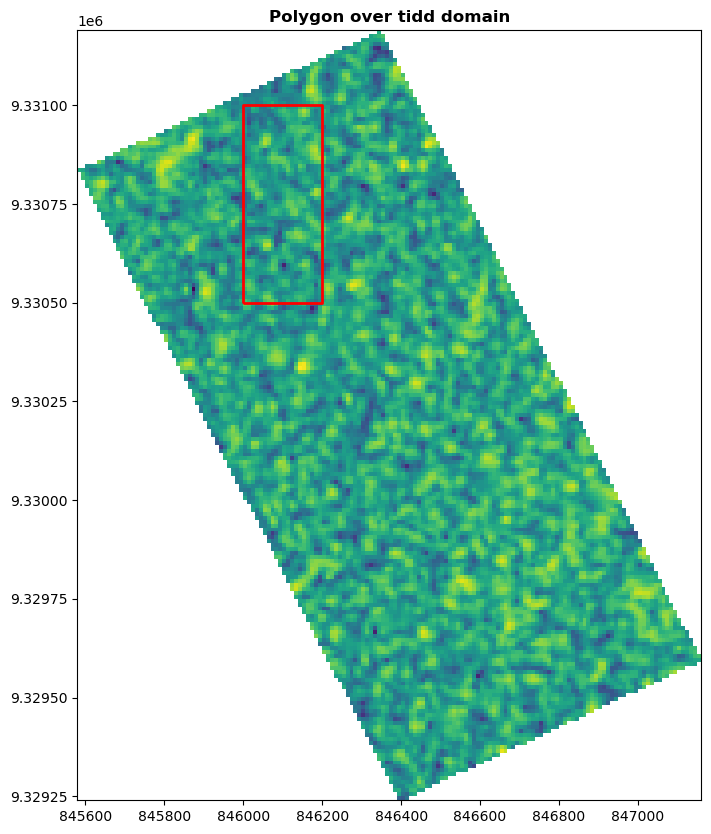

In [7]:
polygon_coords = [
    (846000.0, 9330500.0),
    (846000.0, 9331000.0),
    (846200.0, 9331000.0),
    (846200.0, 9330500.0)
]

polygon = Polygon(polygon_coords)
gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=crs)

# Plot the First TIFF File with the Polygon Overlaid
def plot_tif_with_polygon(tif_path, polygon_gdf):
    with rasterio.open(tif_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, title="Polygon over tiff domain")
        polygon_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
        ax.set_xlim(src.bounds.left, src.bounds.right)
        ax.set_ylim(src.bounds.bottom, src.bounds.top)
        plt.show()

# Plot the poly over tiff domain
plot_tif_with_polygon(os.path.join(time_series_dir, tif_files[0]), gdf)

# Load model and define functions

In [5]:
# Load the SVM Model and Scaler
model_path = r'D:\Development\RESEARCH\MarvinBlue\Results\svm_model.pkl'
forest_classifier = joblib.load(model_path)

scaler_path = r'D:\Development\RESEARCH\MarvinBlue\Results\scaler.pkl'
scaler = joblib.load(scaler_path)

# Define the Feature Extraction Function
def extract_features(image_data):
    """Extract features from the first two bands (VV, VH) only."""
    band1, band2 = image_data[0], image_data[1]

    # Skip processing if the data is invalid (all NaN or empty)
    if np.all(np.isnan(band1)) or np.all(np.isnan(band2)) or band1.size == 0 or band2.size == 0:
        print("Skipping empty or all-NaN data slice.")
        return None
    
    # If valid, proceed with feature extraction
    return np.vstack([band1.flatten(), band2.flatten()]).T

## Optional: Include Band 3 as feature 
# def extract_features(image_data):
#     """Extract features from the first two bands (VV, VH) and their ratios to the mean of the incidence angle."""
#     band1, band2, band3 = image_data
#     band3_mean = np.nanmean(band3)
#     band1_flat = band1.flatten()
#     band2_flat = band2.flatten()
#     band1_ratio = band1_flat / band3_mean
#     band2_ratio = band2_flat / band3_mean
#     features = np.vstack([band1_flat, band2_flat, band1_ratio, band2_ratio]).T
#     return features

def extract_date_from_filename(filename):
    """Extract the date from the filename."""
    date_str = filename.split('_')[4]
    return datetime.strptime(date_str, "%Y%m%dT%H%M%S").date()

# Define the Deforestation Detection Functions
def is_deforested_rate_of_change(previous_percentage, current_percentage, threshold=10):
    """Check if the rate of increase in non-forest percentage exceeds the threshold."""
    return (current_percentage - previous_percentage) > threshold

def is_deforested_rate_and_level(previous_percentage, current_percentage, threshold=50, rate_threshold=10):
    """
    Determine deforestation based on the rate of change and percentage level.
    - `threshold`: The absolute percentage level above which deforestation is flagged.
    - `rate_threshold`: The minimum rate of increase in non-forest percentage to flag deforestation.
    """
    rate_of_change = (current_percentage - previous_percentage) > rate_threshold
    exceeds_threshold = current_percentage > threshold
    return rate_of_change and exceeds_threshold

def check_temporal_consistency(non_forest_summary, window_size=3, threshold=50):
    """Check if there's a consistent increase in non-forest percentage over multiple time steps."""
    smoothed_data = smooth_data([percentage for _, percentage in non_forest_summary], window_size)
    return all(x > threshold for x in smoothed_data[-window_size:])

def smooth_data(data, window_size=5):
    """Apply a moving average to the data to smooth out short-term fluctuations."""
    if len(data) < window_size:
        return pd.Series(data)
    
    smoothed = pd.Series(data).rolling(window=window_size).apply(lambda x: np.nanmean(x), raw=True)
    
    return smoothed.fillna(method='bfill').fillna(method='ffill')

# main function, define here your method
def classify_and_detect_deforestation(polygon_gdf, tif_files, method='rate_and_level'):
    """
    Detect deforestation using different methods:
    - 'rate_of_change': Checks for a sudden increase in non-forest area.
    - 'rate_and_level': Combines rate of change and absolute threshold criteria.
    - 'temporal_consistency': Looks for consistent changes over time.
    """
    tif_files = sorted(tif_files, key=extract_date_from_filename)
    
    previous_classification = None
    total_files = len(tif_files)
    non_forest_summary = []
    initial_predictions = None
    initial_file_date = None
    deforestation_detected = False
    deforestation_event_date = None

    for index, tif_file in enumerate(tif_files):
        sys.stdout.write(f"\rProcessing file {index + 1} out of {total_files}...")
        sys.stdout.flush()

        tif_path = os.path.join(time_series_dir, tif_file)
        with rasterio.open(tif_path) as src:
            out_image, out_transform = mask(src, polygon_gdf.geometry, crop=True)
            out_image = out_image.astype(np.float32)
            out_image = np.nan_to_num(out_image, nan=-9999)

            h, w = out_image.shape[1], out_image.shape[2]
            valid_features = []

            for i in range(h):
                for j in range(w):
                    tile_features = extract_features(out_image[:, i:i+1, j:j+1])
                    if tile_features is not None:
                        valid_features.append(tile_features)

            if not valid_features:
                continue

            valid_features = np.vstack(valid_features)
            valid_features_normalized = scaler.transform(valid_features)
            predictions = forest_classifier.predict(valid_features_normalized).reshape(h, w)

            if initial_predictions is None:
                initial_predictions = predictions
                initial_file_date = extract_date_from_filename(tif_file)

            non_forest_pixels = np.sum(predictions == 0)
            total_pixels = predictions.size
            non_forest_percentage = (non_forest_pixels / total_pixels) * 100
            file_date = extract_date_from_filename(tif_file)
            non_forest_summary.append((file_date, non_forest_percentage))

            if method == 'rate_and_level':
                if index > 0:
                    if is_deforested_rate_and_level(non_forest_summary[index-1][1], non_forest_percentage):
                        if not deforestation_detected:
                            deforestation_detected = True
                            deforestation_event_date = file_date
            elif method == 'temporal_consistency':
                if check_temporal_consistency(non_forest_summary):
                    if not deforestation_detected:
                        deforestation_detected = True
                        deforestation_event_date = file_date

            if deforestation_detected and deforestation_event_date == file_date:
                print(f"\nDeforestation detected on: {file_date.strftime('%m-%Y')}")
                visualize_predictions(initial_predictions, initial_file_date, predictions, file_date, out_transform)
                visualize_change_groups(initial_predictions, predictions, initial_file_date, file_date, out_transform)

            previous_classification = predictions

    if not deforestation_detected:
        print("\nNo significant deforestation detected in the given time series.")
    else:
        print(f"\nDeforestation first detected on: {deforestation_event_date.strftime('%m-%Y')}")

    plot_non_forest_percentage(non_forest_summary, tif_files, deforestation_event_date)

def plot_non_forest_percentage(non_forest_summary, tif_files, deforestation_event_date=None):
    """Plot the non-forest percentage over time with custom point colors based on file name prefix."""
    dates, percentages = zip(*non_forest_summary)

    colors = ['green' if tif_file.startswith('S1A') else 'blue' for tif_file in tif_files]

    plt.figure(figsize=(14, 7))
    plt.plot(dates, percentages, linestyle='-', color='blue', alpha=0.7, label='Non-Forest %')

    for i, (date, percentage) in enumerate(zip(dates, percentages)):
        plt.scatter(date, percentage, color=colors[i], s=50)

    if deforestation_event_date:
        plt.axvline(x=deforestation_event_date, color='red', linestyle='--', label=f'Deforestation Date: {deforestation_event_date.strftime("%m-%Y")}')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()

    plt.xlabel('Date')
    plt.ylabel('Non-Forest Percentage (%)')
    plt.title('Non-Forest Percentage Over Time')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

def visualize_predictions(initial_predictions, initial_file_date, final_predictions, final_file_date, transform):
    """Visualize the initial and final predictions side by side with a binary legend and projection values."""
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    cmap = mcolors.ListedColormap(['brown', 'green'])
    
    im1 = axes[0].imshow(initial_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * initial_predictions.shape[1],
                                                                 transform[5] + transform[4] * initial_predictions.shape[0], transform[5]])
    axes[0].set_title(f"Initial Predictions on {initial_file_date}")
    axes[0].set_xlabel("X Projection (m)")
    axes[0].set_ylabel("Y Projection (m)")
    axes[0].set_xticks(np.linspace(transform[2], transform[2] + transform[0] * initial_predictions.shape[1], num=5))
    
    im2 = axes[1].imshow(final_predictions, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * final_predictions.shape[1],
                                                               transform[5] + transform[4] * final_predictions.shape[0], transform[5]])
    axes[1].set_title(f"Predictions on {final_file_date}")
    axes[1].set_xlabel("X Projection (m)")
    axes[1].set_ylabel("Y Projection (m)")
    axes[1].set_xticks(np.linspace(transform[2], transform[2] + transform[0] * final_predictions.shape[1], num=5))
    
    # Ensure tight layout to prevent overlap
    plt.tight_layout()

    # Custom legend
    legend_labels = {0: 'Non-Forest', 1: 'Forest'}
    patches = [plt.matplotlib.patches.Patch(color=cmap(i), label=legend_labels[i]) for i in legend_labels]
    fig.legend(handles=patches, bbox_to_anchor=(0.5, 0), loc='upper center', ncol=2)
    
    plt.show()

def visualize_change_groups(initial_predictions, final_predictions, initial_file_date, final_file_date, transform):
    """Visualize the changes in land cover with four groups."""
    
    min_h = min(initial_predictions.shape[0], final_predictions.shape[0])
    min_w = min(initial_predictions.shape[1], final_predictions.shape[1])
    
    initial_predictions = initial_predictions[:min_h, :min_w]
    final_predictions = final_predictions[:min_h, :min_w]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    map_output = np.zeros_like(initial_predictions)

    map_output[(initial_predictions == 1) & (final_predictions == 1)] = 1  
    map_output[(initial_predictions == 1) & (final_predictions == 0)] = 2  
    map_output[(initial_predictions == 0) & (final_predictions == 0)] = 3  
    map_output[(initial_predictions == 0) & (final_predictions == 1)] = 4  

    cmap = mcolors.ListedColormap(['green', 'red', 'brown', 'lightgreen'])
    
    im = ax.imshow(map_output, cmap=cmap, extent=[transform[2], transform[2] + transform[0] * map_output.shape[1],
                                                  transform[5] + transform[4] * map_output.shape[0], transform[5]])

    ax.set_title(f"Land Cover Change: Initial ({initial_file_date}) to Deforestation ({final_file_date})")
    ax.set_xlabel("X Projection (m)")
    ax.set_ylabel("Y Projection (m)")

    legend_labels = {
        1: 'Forest stayed Forest',
        2: 'Forest deforested',
        3: 'Non-Forest stayed Non-Forest',
        4: 'Non-Forest became Forest'
    }
    patches = [plt.matplotlib.patches.Patch(color=cmap(i-1), label=legend_labels[i]) for i in range(1, 5)]
    fig.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Run the Deforestation Detection 

Processing file 191 out of 241...
Deforestation detected on: 08-2021


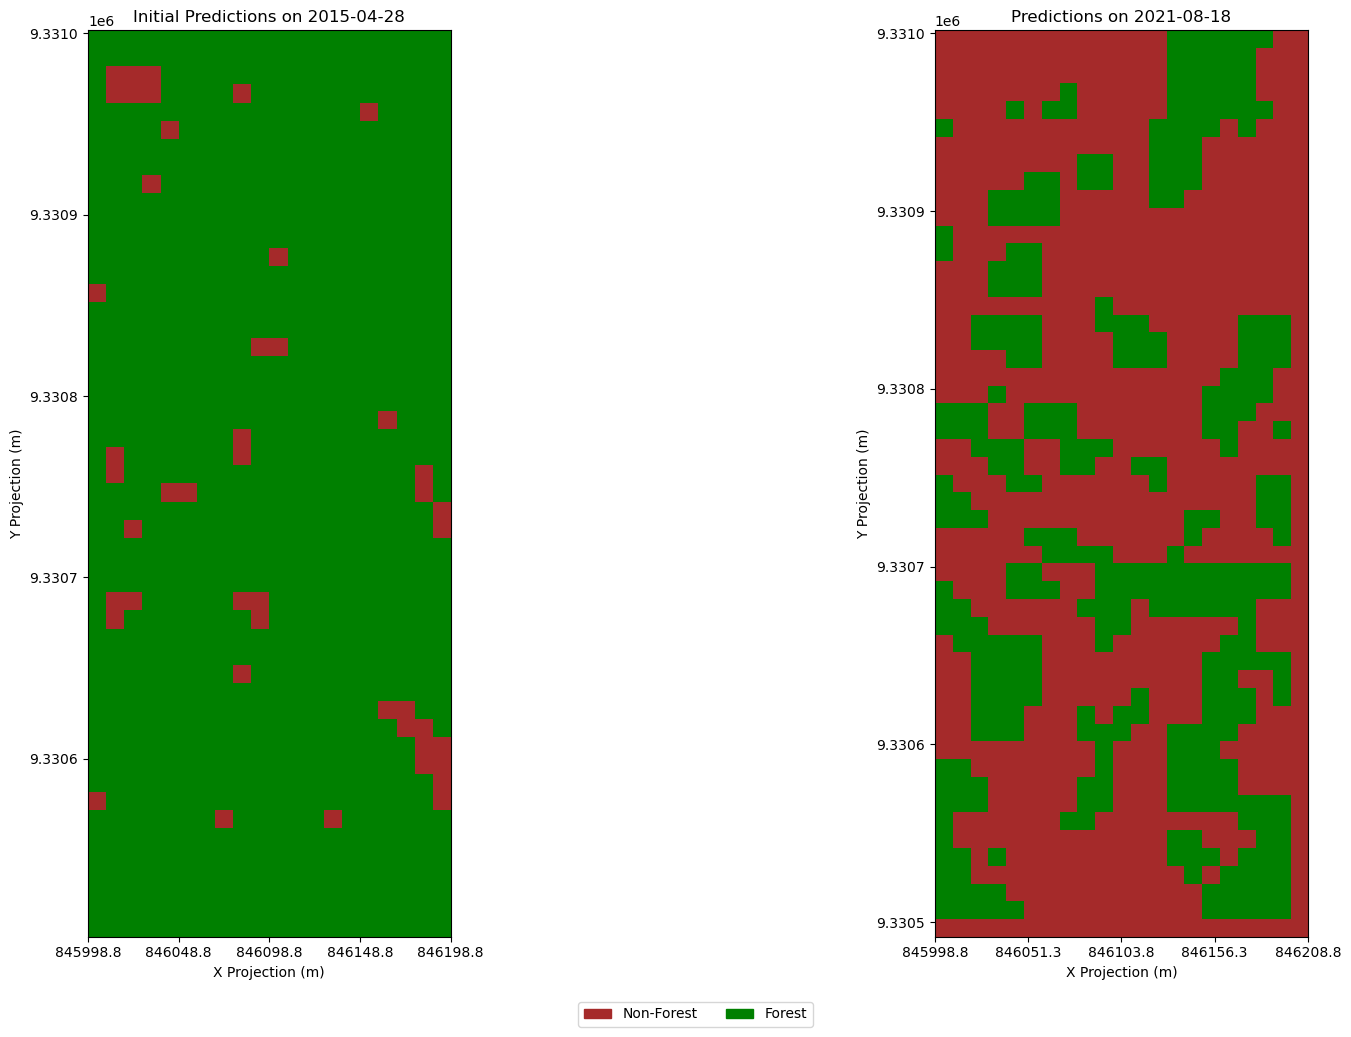

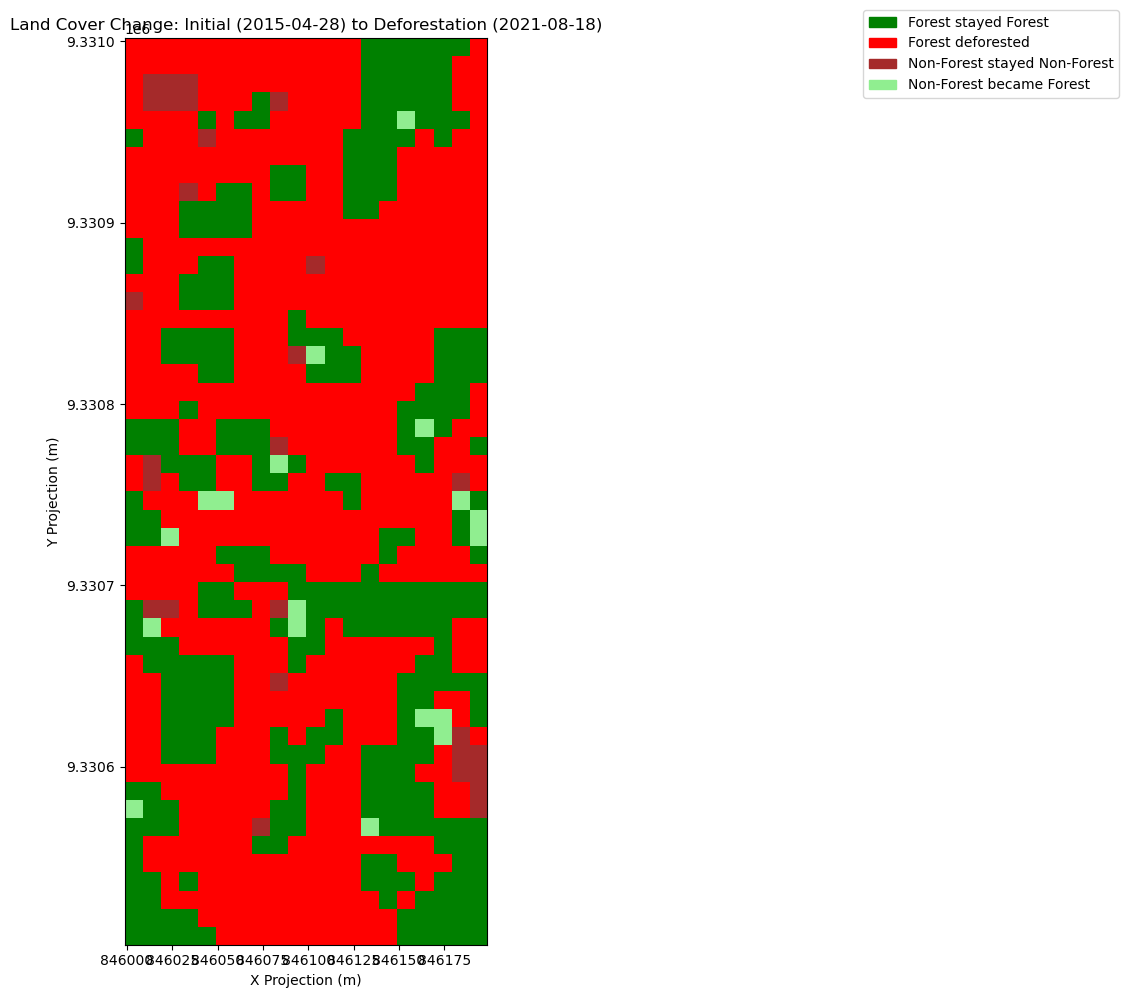

Processing file 241 out of 241...
Deforestation first detected on: 08-2021


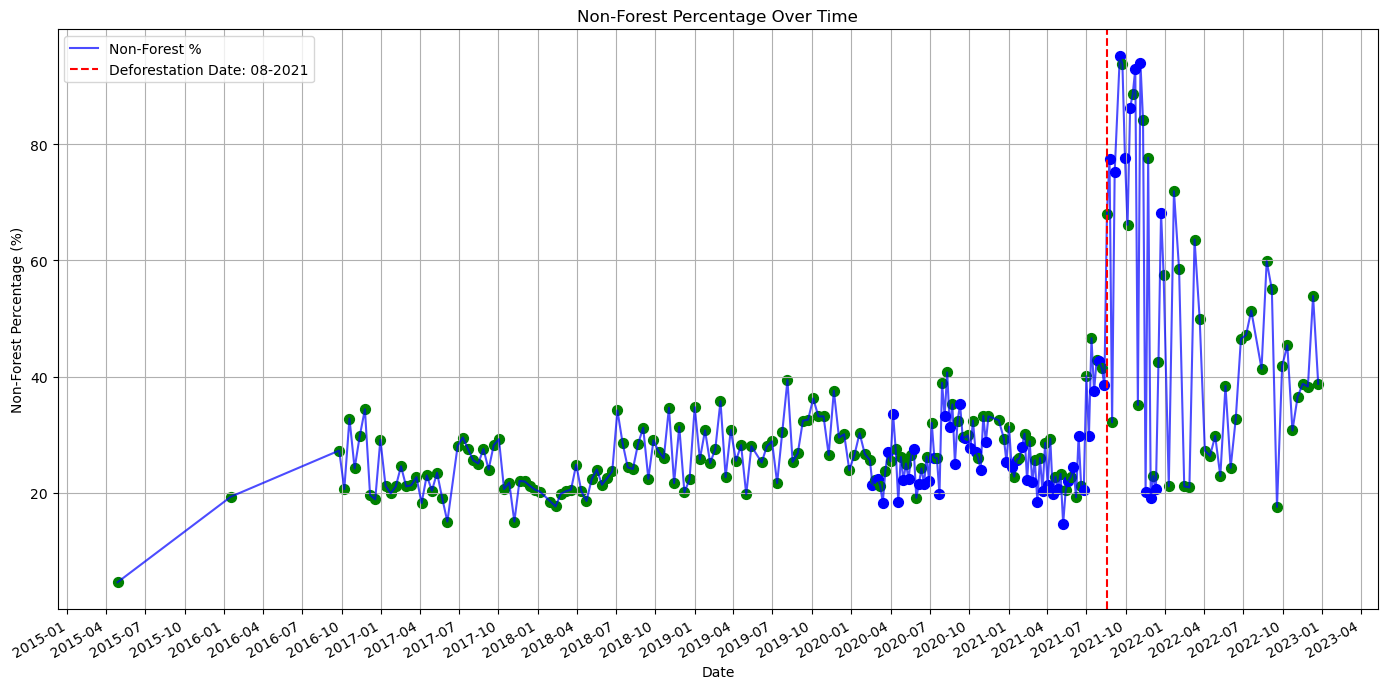

In [6]:
classify_and_detect_deforestation(gdf, tif_files, method='rate_and_level')